In [1]:
import gzip
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
from PIL import Image
import os
import shutil
import json
import io

# Inspect full image archive without extracting all files

In [2]:
%%time
# https://github.com/alexeygrigorev/clothing-dataset
zipf = zipfile.ZipFile('clothing_dataset.zip')

CPU times: user 105 ms, sys: 5.26 ms, total: 110 ms
Wall time: 110 ms


In [3]:
filenames = zipf.namelist()
df = pd.DataFrame([x.split('/') for x in filenames[:]], columns=['root_path', 'filename'])
df['path'] = filenames

In [4]:
df = df.dropna()
df = df[df.filename != '']
df = df.reset_index()
df['image'] = df.filename.apply(lambda x: x.split('.')[0])
print(len(df))
df.sample(n=5)

11524


,index,root_path,filename,path,image
6020,6021,images_original,0b1cc7a6-be78-45e6-be22-2ad00b107328.jpg,images_original/0b1cc7a6-be78-45e6-be22-2ad00b...,0b1cc7a6-be78-45e6-be22-2ad00b107328
11312,11313,images_original,f774012e-46d4-4cd6-a22b-b16f1262e613.jpg,images_original/f774012e-46d4-4cd6-a22b-b16f12...,f774012e-46d4-4cd6-a22b-b16f1262e613
371,372,images_compressed,106b79da-fc83-4be8-b138-0dc23b701541.jpg,images_compressed/106b79da-fc83-4be8-b138-0dc2...,106b79da-fc83-4be8-b138-0dc23b701541
7646,7647,images_original,5369c103-dfa5-4484-af22-17b7adbf55f9.jpg,images_original/5369c103-dfa5-4484-af22-17b7ad...,5369c103-dfa5-4484-af22-17b7adbf55f9
11384,11385,images_original,fa5fe172-a5b0-465a-bf25-7e22e7af43cf.jpg,images_original/fa5fe172-a5b0-465a-bf25-7e22e7...,fa5fe172-a5b0-465a-bf25-7e22e7af43cf


In [5]:
osize = 0 
for item in zipf.infolist():
    osize += item.file_size
print('uncompressed size =',round(osize/1000000000,2),'GB')

uncompressed size = 7.07 GB


### Load category data

In [6]:
df_meta = pd.read_csv('clothing-dataset.csv')

In [7]:
df = pd.merge(df, df_meta, on='image')

# Basic EDA


In [8]:
print(np.unique(df.label.values))
len(np.unique(df.label.values))

['Blazer' 'Blouse' 'Body' 'Dress' 'Hat' 'Hoodie' 'Longsleeve' 'Not sure'
 'Other' 'Outwear' 'Pants' 'Polo' 'Shirt' 'Shoes' 'Shorts' 'Skip' 'Skirt'
 'T-Shirt' 'Top' 'Undershirt']


20

In [9]:
df.groupby('label').count().sort_values('image', ascending=False)[:15]

,index,root_path,filename,path,image,sender_id,kids
label,,,,,,,
T-Shirt,2022,2022,2022,2022,2022,2022,2022
Longsleeve,1398,1398,1398,1398,1398,1398,1398
Pants,1384,1384,1384,1384,1384,1384,1384
Shoes,862,862,862,862,862,862,862
Shirt,756,756,756,756,756,756,756
Dress,714,714,714,714,714,714,714
Outwear,624,624,624,624,624,624,624
Shorts,616,616,616,616,616,616,616
Not sure,456,456,456,456,456,456,456


### Inspect a few sample images and corresponding bounding boxes (BBOX is 100% for these)

In [10]:
df = df[df.root_path=='images_original']

In [11]:
len(df)

5403

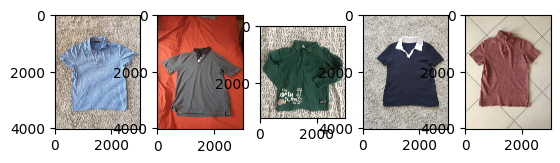

In [12]:
samples = df[df.label=='Polo'].sample(5)

fig, ax = plt.subplots(1,5)
i=0
for idx, row in samples.iterrows():
    img = Image.open(io.BytesIO(zipf.read(row.path)))
    ax[i].imshow(img)
    i+=1
plt.show()

# Merge & Filter Categories

By inspecting a few samples images I noticed that:

- Shorts and skirts are visually very similar
- Shirts contains both short and long-sleeve
- Short-sleeve can include T's and Polos

Actions:
- Merge shorts and skirts
- Include all polos and sample of T-shirts
- Keep Pants and Longsleeve

In [13]:
df_mod = df.copy()

In [14]:
df_mod.loc[df_mod.label=='Shorts','label'] = 'shorts'
df_mod.loc[df_mod.label=='Skirt','label'] = 'shorts'
df_mod.loc[df_mod.label=='Longsleeve','label'] = 'long sleeve top'
df_mod.loc[df_mod.label=='Pants','label'] = 'trousers'
df_mod.loc[df_mod.label=='Polo','label'] = 'short sleeve top'

In [15]:
sample_idx = df_mod[df_mod.label=='T-Shirt'].sample(500).image
df_mod.loc[df_mod.image.isin(sample_idx),'label'] = 'short sleeve top'

In [16]:
df_mod.groupby('label').count().sort_values('image', ascending=False)[:6]

,index,root_path,filename,path,image,sender_id,kids
label,,,,,,,
long sleeve top,699,699,699,699,699,699,699
trousers,692,692,692,692,692,692,692
short sleeve top,620,620,620,620,620,620,620
T-Shirt,511,511,511,511,511,511,511
shorts,463,463,463,463,463,463,463
Shoes,431,431,431,431,431,431,431


In [17]:
# to be comparable with the test on 16k DF1
cats = ['long sleeve top', 
        'short sleeve top', 
        'shorts', 
        'trousers']

In [18]:
samples = df_mod[df_mod.label.isin(cats)]
samples.groupby('label').count().sort_values('image', ascending=False)

,index,root_path,filename,path,image,sender_id,kids
label,,,,,,,
long sleeve top,699,699,699,699,699,699,699
trousers,692,692,692,692,692,692,692
short sleeve top,620,620,620,620,620,620,620
shorts,463,463,463,463,463,463,463


# Prepare train/val split

In [19]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(samples, test_size=0.2)
print(len(train),len(val))

1979 495


In [20]:
# is it still balanced?
train.groupby('label').count().sort_values('image', ascending=False)

,index,root_path,filename,path,image,sender_id,kids
label,,,,,,,
trousers,566,566,566,566,566,566,566
long sleeve top,544,544,544,544,544,544,544
short sleeve top,498,498,498,498,498,498,498
shorts,371,371,371,371,371,371,371


In [21]:
train.iloc[0]

index                                                     8241
root_path                                      images_original
filename              6ce43abd-eb73-474b-bc3d-f8da15d83593.jpg
path         images_original/6ce43abd-eb73-474b-bc3d-f8da15...
image                     6ce43abd-eb73-474b-bc3d-f8da15d83593
sender_id                                                  310
label                                                   shorts
kids                                                     False
Name: 4643, dtype: object

In [22]:
if not os.path.exists('clothdata'):
    os.mkdir('clothdata')

if not os.path.exists('clothdata/images'):
    os.mkdir('clothdata/images')
if not os.path.exists('clothdata/images/train'):
    os.mkdir('clothdata/images/train')
if not os.path.exists('clothdata/images/val'):
    os.mkdir('clothdata/images/val')

if not os.path.exists('clothdata/labels'):
    os.mkdir('clothdata/labels')
if not os.path.exists('clothdata/labels/train'):
    os.mkdir('clothdata/labels/train')
if not os.path.exists('clothdata/labels/val'):
    os.mkdir('clothdata/labels/val')

In [23]:
def createFiles(data=train, type_='train'):
    target_dim = 640.0
    for i, row in tqdm(data.iterrows()):
        filepath = row.path
        img = Image.open(io.BytesIO(zipf.read(filepath)))
        w_orig = float(img.size[0])
        h_orig = float(img.size[1])
        img.thumbnail((target_dim, target_dim)) 
        if 'png' in str(type(img)).lower():
            img = img.convert('RGB')
        img.save('clothdata/images/'+type_+'/'+row.filename, 'JPEG', optimize=True)

        idx = cats.index(row.label)
        metadata = str(idx) + ' 0.5 0.5 1.0 1.0'
        fileroot = 'clothdata/labels/'+type_+'/'+row.filename.split('.')[0]+'.txt'

        f = open(fileroot, 'w')
        f.write(metadata)
        f.close()

In [24]:
createFiles(train, type_='train')
createFiles(val, type_='val')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [25]:
lines = []
lines.append('path: ../datasets/clothdata # root dir\n')
lines.append('train: images/train\n')
lines.append('val: images/val\n')
lines.append('test:  # test images (optional)\n')

lines.append('nc: '+str(len(cats))+' # number of classes\n')

str_classes = "[ '" + "',\n'".join(cats) + "' ]"

lines.append('names: '+str_classes + '\n')

f = open('clothdata/clothdata.yaml', 'w')
f.writelines(lines)
f.close()